In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from math import ceil, log2
from sklearn.ensemble import RandomForestClassifier
import openml
from simple_model import  ConformalPredictor, ConformalRankingPredictor, ClassifierModel, LabelRankingModel
import matplotlib.pyplot as plt

In [7]:
def evaluate_models(dataset_id):
    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, _, _ = dataset.get_data(
        target=dataset.default_target_attribute, dataset_format="dataframe"
    )

    # Automatically identify categorical and numerical columns
    categorical_features = X.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    numerical_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

    num_classes = len(np.unique(y))

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1
    )

    # Encode labels
    le = LabelEncoder()

    y_train = le.fit_transform(y_train)
    y_test = le.transform(y_test)

    # Preprocessing for numerical data: Impute missing values, then scale
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
        ]
    )

    # Preprocessing for categorical data: Impute missing values, then one-hot encode
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    if not isinstance(X_train, np.ndarray):
        X_train = X_train.toarray()
    if not isinstance(y_train, np.ndarray):
        y_train = y_train.toarray()

    # clf = ClassifierModel(input_dim = X_train.shape[1], hidden_dim=16, output_dim=y.max()+1)
    rf = RandomForestClassifier()

    clf = ClassifierModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)
    rank = LabelRankingModel(input_dim=X_train.shape[1], hidden_dim=16, output_dim=num_classes)

    num_classes = len(np.unique(y_train))

    batch_size_clf = 32
    val_frac = 0.2
    cal_frac = 1/3
    num_epochs = 35
    learning_rate = 0.01

    cp_net = ConformalPredictor(clf, alpha=0.05)
    cp_rf = ConformalPredictor(rf, alpha=0.05)
    cp_rank = ConformalPredictor(rank, alpha=0.05)

    cp_net.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rank.fit(X_train, y_train, num_epochs=num_epochs, random_state=1, patience=num_epochs, batch_size=batch_size_clf, val_frac=val_frac, cal_size=cal_frac, learning_rate=learning_rate)
    cp_rf.fit(X_train, y_train, cal_size=cal_frac)

    if not isinstance(X_test, np.ndarray):
        X_test = X_test.toarray()
    if not isinstance(y_test, np.ndarray):
        y_test = y_test.toarray()

    def evaluate_method(method):
        pred_sets = method.predict_set(X_test)
        y_test_model = method.model.predict(X_test)
        coverage = np.mean([y_test[i] in pred_sets[i] for i in range(len(y_test))])
        efficiency = np.mean([len(pred_sets[i]) for i in range(len(y_test))])
        print(f"Accuracy {accuracy_score(y_test_model, y_test)}")
        print(f"Coverage {coverage} efficiency {efficiency}")

    # coverage_clf = np.mean([y_test[i] in pred_sets_clf[i] for i in range(len(y_test))])
    # efficiency_clf = np.mean([len(pred_sets_clf[i]) for i in range(len(y_test))])

    print("Random Forest")
    evaluate_method(cp_rf)
    print("\nClassifier Network")
    evaluate_method(cp_net)
    print("\nRanking Network")
    evaluate_method(cp_rank)
for dataset_id in [61, 187, 15, 31, 4534, 1461]:
    print(f"\n\nDataset: {dataset_id}")
    evaluate_models(dataset_id)




Dataset: 61


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9666666666666667
Coverage 0.9666666666666667 efficiency 1.0

Classifier Network
Accuracy 0.9666666666666667
Coverage 0.9666666666666667 efficiency 1.0

Ranking Network
Accuracy 0.9666666666666667
Coverage 0.7666666666666667 efficiency 0.8


Dataset: 187


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9722222222222222
Coverage 0.9722222222222222 efficiency 1.0

Classifier Network
Accuracy 1.0
Coverage 1.0 efficiency 1.0

Ranking Network
Accuracy 1.0
Coverage 1.0 efficiency 1.0277777777777777


Dataset: 15


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9857142857142858
Coverage 0.9857142857142858 efficiency 1.0

Classifier Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0

Ranking Network
Accuracy 0.9785714285714285
Coverage 0.9785714285714285 efficiency 1.0


Dataset: 31


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.74
Coverage 0.965 efficiency 1.645

Classifier Network
Accuracy 0.75
Coverage 0.955 efficiency 1.58

Ranking Network
Accuracy 0.75
Coverage 0.96 efficiency 1.59


Dataset: 4534


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9710538218000905
Coverage 0.9371325192220714 efficiency 0.9552238805970149

Classifier Network
Accuracy 0.9466304839439168
Coverage 0.9443690637720489 efficiency 0.9941203075531434

Ranking Network
Accuracy 0.9511533242876526
Coverage 0.9484396200814111 efficiency 0.9936680235187698


Dataset: 1461


/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/openml/utils.py:461: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  return func(*args, **kwargs)


Random Forest
Accuracy 0.9020236647130377
Coverage 0.9514541634413358 efficiency 1.1156695786796418

Classifier Network
Accuracy 0.9053411478491651
Coverage 0.9526705739245825 efficiency 1.1193188101293818

Ranking Network
Accuracy 0.9033506579674887
Coverage 0.9533340705518081 efficiency 1.1278336835121088


In [4]:
from simple_model import LabelPairDataset

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

X,y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=1/3)
num_classes = len(np.unique(y))


In [6]:
from simple_model import LabelRankingModel
model = LabelRankingModel(input_dim=X_train.shape[1],hidden_dim=16, output_dim=3)
model.fit(X_train,y_train,num_classes=3, random_state=1, batch_size=32, num_epochs=250,patience=250)

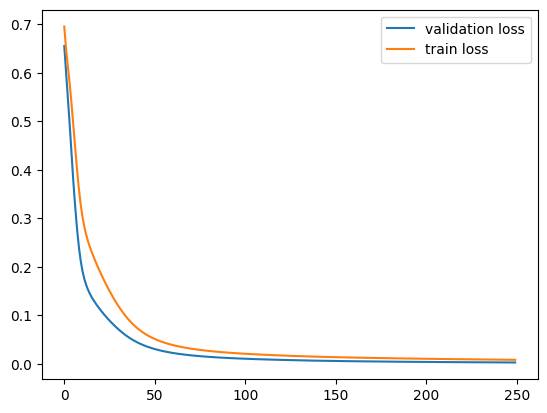

In [7]:
plt.plot(np.arange(len(model.val_losses)), model.val_losses, label="validation loss")
plt.plot(np.arange(len(model.train_losses)), model.train_losses, label="train loss")
plt.legend()
plt.show()

In [10]:
y_pred = model.predict(X_test)

In [11]:
accuracy_score(y_pred,y_test)

0.94